In [2]:
pip install yfinance

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     ----------------- ---------------------- 1.3/3.0 MB 3.9 MB/s eta 0:00:01
     -------------------- ------------------- 1.6/3.0 MB 3.2 MB/s eta 0:00:01
     --------------------------- ------------ 2.1/3.0 MB 2.8 MB/s eta 0:00:01
     --------------------------- ------------ 2.1/3.0 MB 2.8 MB/s eta 0:00:01
     -------------------------------------- - 2.9/3.0 MB 2.4 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 2.3 MB/s  

In [30]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [41]:
data = yf.download("TSLA", start="2018-01-01", progress=False)

C:\Users\PMYLS\AppData\Local\Temp\ipykernel_9000\2381676563.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("TSLA", start="2018-01-01", progress=False)


In [42]:
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]

In [43]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()

In [44]:
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,21.368668,21.474001,20.733334,20.799999,65283000
2018-01-03,21.150000,21.683332,21.036667,21.400000,67822500
2018-01-04,20.974667,21.236668,20.378668,20.858000,149194500
2018-01-05,21.105333,21.149332,20.799999,21.108000,68868000
2018-01-08,22.427334,22.468000,21.033333,21.066668,147891000


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1978 entries, 2018-01-02 to 2025-11-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1978 non-null   float64
 1   High    1978 non-null   float64
 2   Low     1978 non-null   float64
 3   Open    1978 non-null   float64
 4   Volume  1978 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 92.7 KB


In [46]:
data.describe()

,Close,High,Low,Open,Volume
count,1978.000000,1978.000000,1978.000000,1978.000000,1.978000e+03
mean,178.457841,182.484956,174.225646,178.493413,1.247708e+08
std,122.788962,125.558558,119.924156,122.913056,7.646710e+07
min,11.931333,12.445333,11.799333,12.073333,2.940180e+07
25%,25.627499,26.508667,24.621000,25.293334,7.805550e+07
50%,200.224998,204.333328,195.114998,200.141670,1.033526e+08
75%,261.370003,266.577507,256.142502,260.325005,1.428690e+08
max,479.859985,488.540009,457.510010,475.899994,9.140820e+08


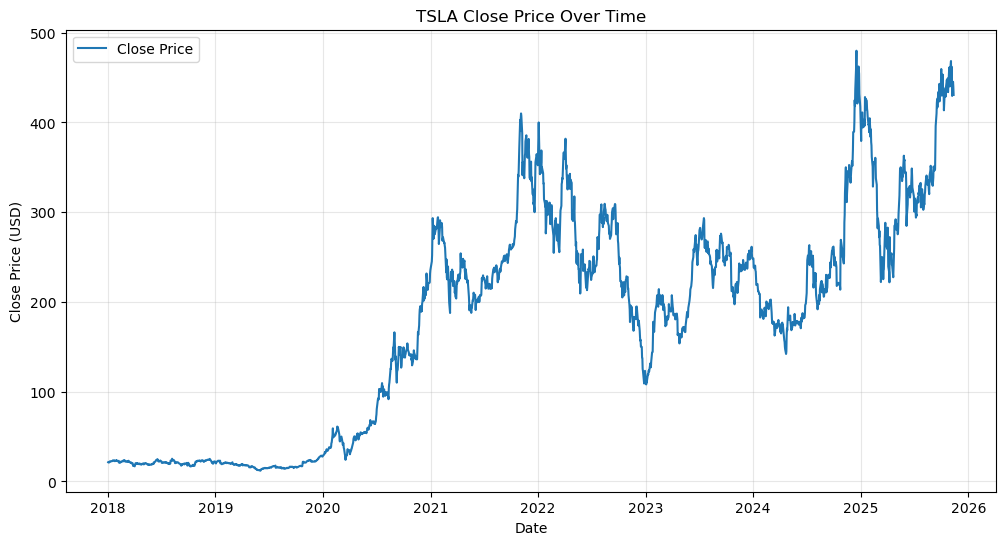

In [47]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label='Close Price')
plt.title("TSLA Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

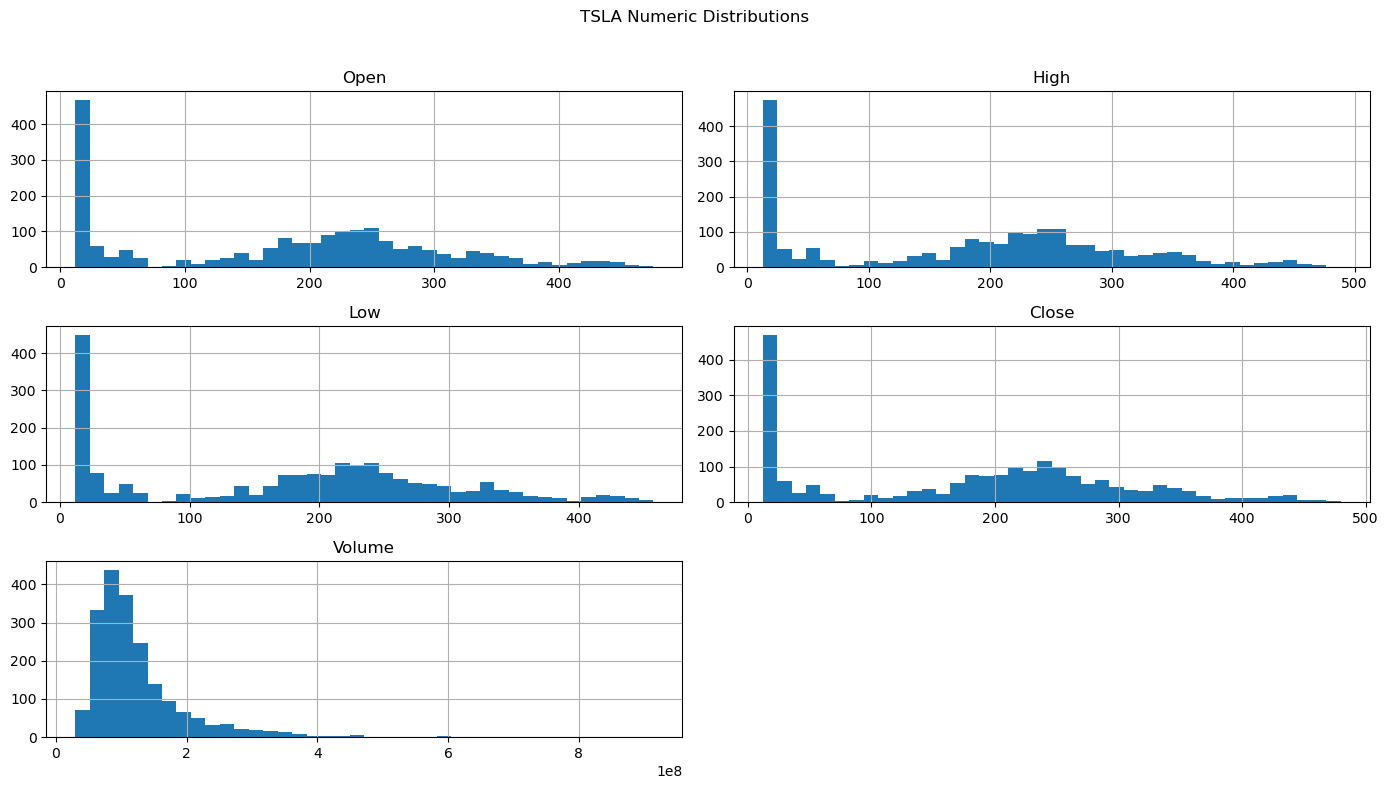

In [48]:
numeric_cols = ['Open','High','Low','Close','Volume']
data[numeric_cols].hist(bins=40, figsize=(14,8))
plt.suptitle("TSLA Numeric Distributions")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [49]:
data['MA7'] = data['Close'].rolling(7).mean()

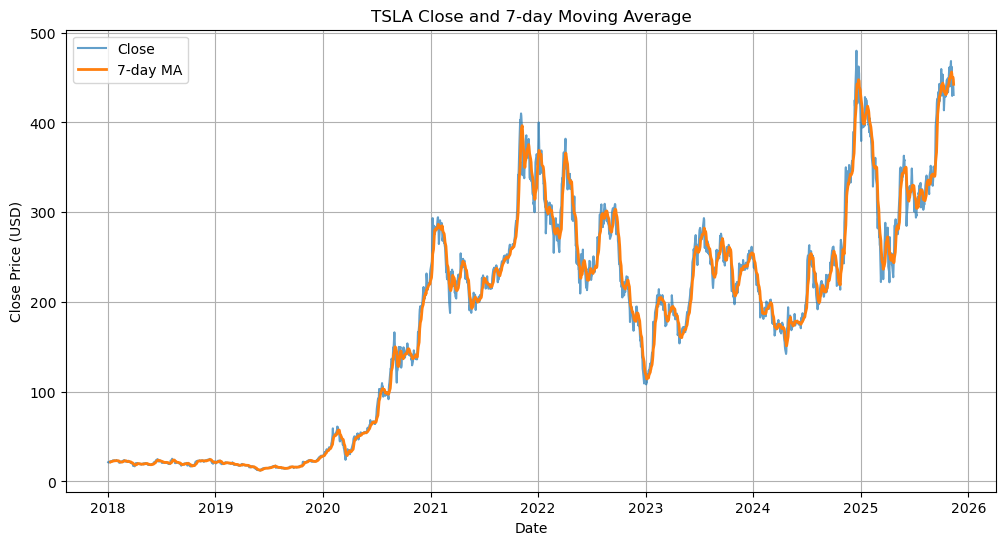

In [50]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close', alpha=0.7)
plt.plot(data['MA7'], label='7-day MA', linewidth=2)
plt.title("TSLA Close and 7-day Moving Average")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

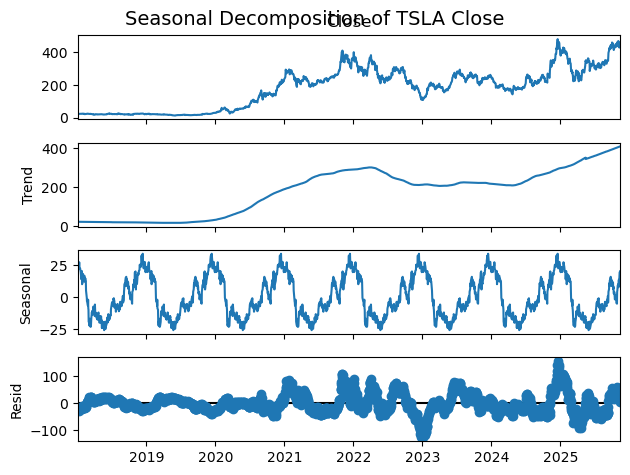

In [51]:
series = data['Close'].dropna()
decomp = seasonal_decompose(series, model='additive', period=252, extrapolate_trend='freq')
decomp.plot()
plt.suptitle("Seasonal Decomposition of TSLA Close", fontsize=14)
plt.show()

In [52]:
volume_series = data['Volume'].dropna()

In [53]:
adf_result = adfuller(volume_series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, val in adf_result[4].items():
    print(f"Critical Value ({key}): {val:.3f}")

ADF Statistic: -3.875847908769993
p-value: 0.002219960899532235
Critical Value (1%): -3.434
Critical Value (5%): -2.863
Critical Value (10%): -2.568


In [54]:
if adf_result[1] < 0.05:
    print("=> Volume series is stationary.")
else:
    print("=> Volume series is non-stationary.")

=> Volume series is stationary.


In [55]:
n_forecast = 30

In [56]:
train_close = series[:-n_forecast]
test_close = series[-n_forecast:]

In [57]:
model_close = ARIMA(train_close, order=(1,0,0))
fit_close = model_close.fit()
print(fit_close.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1948
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6856.845
Date:                Thu, 13 Nov 2025   AIC                          13719.690
Time:                        12:26:35   BIC                          13736.413
Sample:                             0   HQIC                         13725.838
                               - 1948                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.4009    140.822      1.238      0.216    -101.604     450.406
ar.L1          0.9987      0.002    558.014      0.000       0.995       1.002
sigma2        66.6192      1.079     61.726      0.0

C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [58]:
pred_close = fit_close.forecast(steps=n_forecast)
pred_close.index = test_close.index

C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [59]:
mae_close = mean_absolute_error(test_close, pred_close)
print("MAE (Close):", mae_close)

MAE (Close): 15.333759927984415


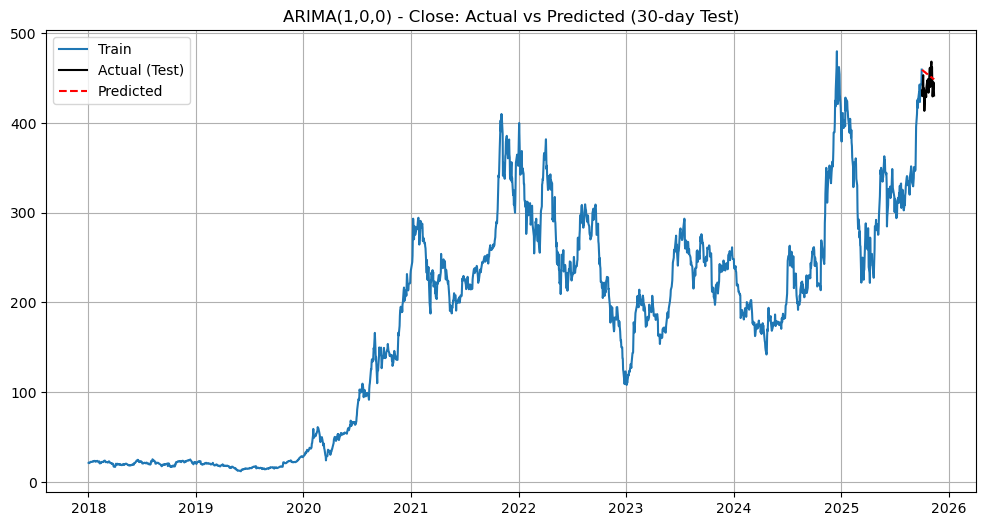

In [60]:
plt.figure(figsize=(12,6))
plt.plot(train_close.index, train_close, label='Train')
plt.plot(test_close.index, test_close, label='Actual (Test)', color='black')
plt.plot(pred_close.index, pred_close, label='Predicted', color='red', linestyle='--')
plt.title("ARIMA(1,0,0) - Close: Actual vs Predicted (30-day Test)")
plt.legend()
plt.grid(True)
plt.show()

In [61]:
fit_close_full = ARIMA(series, order=(1,0,0)).fit()
future_index = pd.bdate_range(start=series.index[-1] + pd.Timedelta(days=1), periods=n_forecast)
future_forecast_close = fit_close_full.forecast(steps=n_forecast)
future_forecast_close.index = future_index

C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

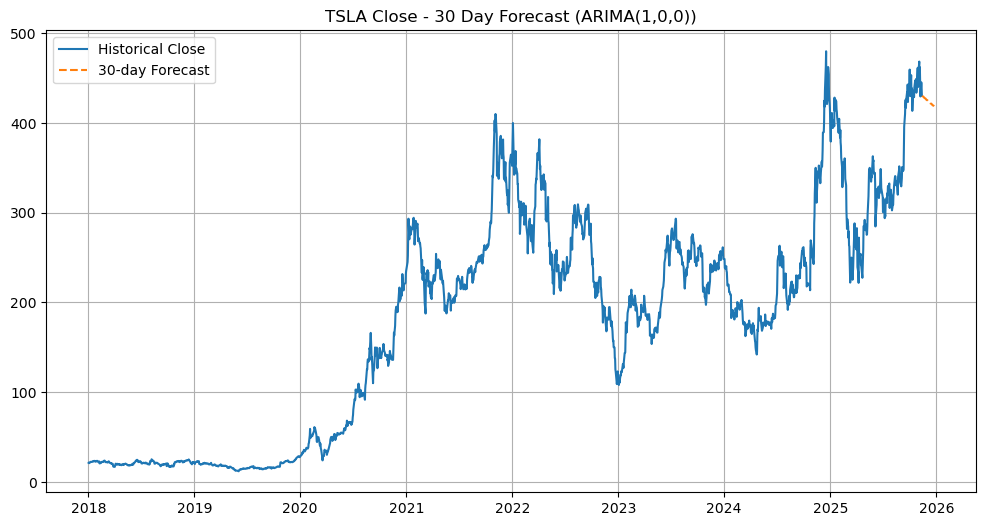

In [62]:
plt.figure(figsize=(12,6))
plt.plot(series.index, series, label='Historical Close')
plt.plot(future_forecast_close.index, future_forecast_close, label='30-day Forecast', linestyle='--')
plt.title("TSLA Close - 30 Day Forecast (ARIMA(1,0,0))")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
train_vol = volume_series[:-n_forecast]
test_vol = volume_series[-n_forecast:]

In [64]:
model_vol = ARIMA(train_vol, order=(1,0,0))
fit_vol = model_vol.fit()
print(fit_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                 1948
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -37327.956
Date:                Thu, 13 Nov 2025   AIC                          74661.912
Time:                        12:29:23   BIC                          74678.635
Sample:                             0   HQIC                         74668.061
                               - 1948                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.254e+08   4.89e-12   2.56e+19      0.000    1.25e+08    1.25e+08
ar.L1          0.7503      0.007    112.440      0.000       0.737       0.763
sigma2      2.579e+15   2.04e-19   1.26e+34      0.0

C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [65]:
pred_vol = fit_vol.forecast(steps=n_forecast)
pred_vol.index = test_vol.index
mae_vol = mean_absolute_error(test_vol, pred_vol)
print("MAE (Volume):", mae_vol)

MAE (Volume): 39749886.380660824


C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\PMYLS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


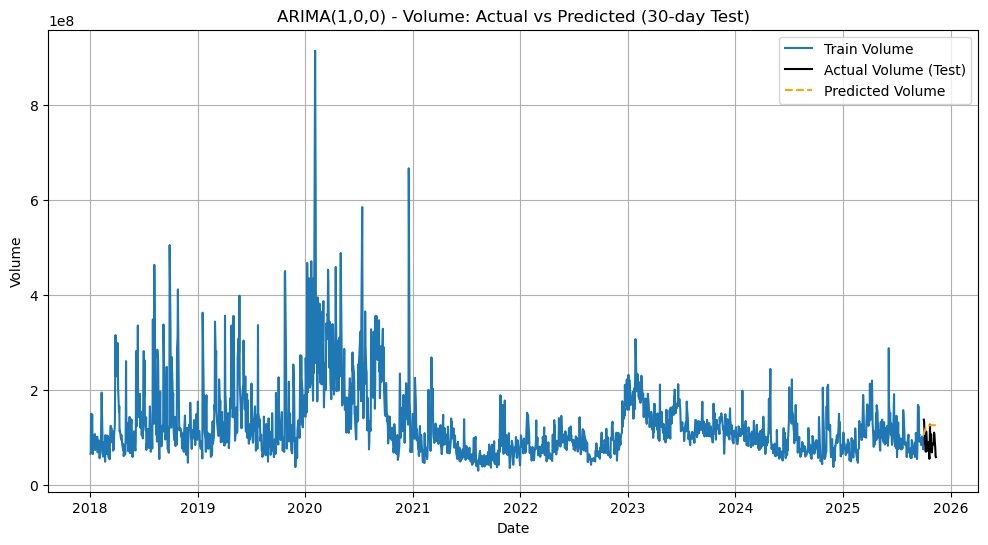

In [66]:
plt.figure(figsize=(12,6))
plt.plot(train_vol.index, train_vol, label='Train Volume')
plt.plot(test_vol.index, test_vol, label='Actual Volume (Test)', color='black')
plt.plot(pred_vol.index, pred_vol, label='Predicted Volume', color='orange', linestyle='--')
plt.title("ARIMA(1,0,0) - Volume: Actual vs Predicted (30-day Test)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()